In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Uterus/')]
groups = ['Histone','TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Uterus/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/244 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("uterus.bed", "r") as bed_file:

    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
win_in = []
win_out = []
width = 50000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
win_in[:10]

[['chr1', 192302683, 192352683],
 ['chr1', 52529755, 52579755],
 ['chr1', 199475805, 199525805],
 ['chr1', 42960478, 43010478],
 ['chr1', 58647136, 58697136],
 ['chr1', 185042532, 185092532],
 ['chr1', 16866926, 16916926],
 ['chr1', 191251054, 191301054],
 ['chr1', 54485616, 54535616],
 ['chr1', 151560821, 151610821]]

In [7]:
win_out[:10]

[['chr1', 191302683, 191352683],
 ['chr1', 190802683, 190852683],
 ['chr1', 190552683, 190602683],
 ['chr1', 190802683, 190852683],
 ['chr1', 191302683, 191352683],
 ['chr1', 192302683, 192352683],
 ['chr1', 51529755, 51579755],
 ['chr1', 51029755, 51079755],
 ['chr1', 50779755, 50829755],
 ['chr1', 51029755, 51079755]]

In [8]:
print(len(win_in), len(win_out))

4147 23699


In [9]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in) * 2, replace=False)]

In [10]:
print(len(ints_in1), len(ints_out1))

4147 8294


In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr14', '97363775', '97413775', '0'],
       ['chr14', '105090108', '105140108', '1'],
       ['chr3', '34309037', '34359037', '0'],
       ['chr2', '26783365', '26833365', '1'],
       ['chr2', '71056011', '71106011', '1'],
       ['chr16', '85363004', '85413004', '1'],
       ['chr8', '38824760', '38874760', '0'],
       ['chr19', '54639152', '54689152', '1'],
       ['chr3', '11021892', '11071892', '1'],
       ['chr19', '51296786', '51346786', '0']], dtype='<U21')

In [12]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12441/12441 [06:18<00:00, 32.87it/s]


In [13]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [14]:
X = np.array(X)
X

array([[-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493],
       [-0.24220268, -0.02416427,  0.5640395 , ..., -0.10603009,
        -0.04497766, -0.06474493],
       [-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493],
       ...,
       [-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493],
       [ 0.10208094, -0.02416427, -0.21340568, ..., -0.06709284,
        -0.04497766, -0.06474493],
       [-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493]], dtype=float32)

In [15]:
X.shape

(12441, 244)

In [16]:
y

tensor([0, 1, 0,  ..., 0, 1, 0])

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-16 15:08:27.750297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 15:08:28.343459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
311/311 [==============================] - 4s 12ms/step - loss: 0.6379 - accuracy: 0.6672 - val_loss: 0.6380 - val_accuracy: 0.6641
Epoch 2/10
311/311 [==============================] - 4s 11ms/step - loss: 0.6365 - accuracy: 0.6673 - val_loss: 0.6383 - val_accuracy: 0.6641
Epoch 3/10
311/311 [==============================] - 3s 11ms/step - loss: 0.6359 - accuracy: 0.6672 - val_loss: 0.6379 - val_accuracy: 0.6645
Epoch 4/10
311/311 [==============================] - 4s 11ms/step - loss: 0.6361 - accuracy: 0.6672 - val_loss: 0.6380 - val_accuracy: 0.6645
Epoch 5/10
311/311 [==============================] - 3s 11ms/step - loss: 0.6362 - accuracy: 0.6674 - val_loss: 0.6403 - val_accuracy: 0.6641
Epoch 6/10
311/311 [==============================] - 3s 11ms/step - loss: 0.6356 - accuracy: 0.6674 - val_loss: 0.6380 - val_accuracy: 0.6645
Epoch 7/10
311/311 [==============================] - 4s 11ms/step - loss: 0.6359 - accuracy: 0.6670 - val_loss: 0.6380 - val_accuracy: 0.6641

In [18]:
X

array([[-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493],
       [-0.24220268, -0.02416427,  0.5640395 , ..., -0.10603009,
        -0.04497766, -0.06474493],
       [-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493],
       ...,
       [-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493],
       [ 0.10208094, -0.02416427, -0.21340568, ..., -0.06709284,
        -0.04497766, -0.06474493],
       [-0.24220268, -0.02416427, -0.21340568, ..., -0.20157517,
        -0.04497766, -0.06474493]], dtype=float32)

In [19]:
y

tensor([0, 1, 0,  ..., 0, 1, 0])

In [20]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [21]:
X = X_copy
y = y_copy

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1416/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1416/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6371, Train F1-score: 0.3043, Train ROC-AUC: 0.3594, Train PR-AUC: 0.3907, Test Loss: 0.6359, Test F1-score: 0.5429, Test ROC-AUC: 0.5265, Test PR-AUC: 0.3702
Epoch [2/20], Train Loss: 0.6266, Train F1-score: 0.4808, Train ROC-AUC: 0.4667, Train PR-AUC: 0.4863, Test Loss: 0.6354, Test F1-score: 0.5443, Test ROC-AUC: 0.5423, Test PR-AUC: 0.3728
Epoch [3/20], Train Loss: 0.6176, Train F1-score: 0.7836, Train ROC-AUC: 0.6182, Train PR-AUC: 0.6143, Test Loss: 0.6392, Test F1-score: 0.5683, Test ROC-AUC: 0.5482, Test PR-AUC: 0.3720
Epoch [4/20], Train Loss: 0.6040, Train F1-score: 0.5636, Train ROC-AUC: 0.6719, Train PR-AUC: 0.7521, Test Loss: 0.6491, Test F1-score: 0.5699, Test ROC-AUC: 0.5426, Test PR-AUC: 0.3682
Epoch [5/20], Train Loss: 0.5851, Train F1-score: 0.7500, Train ROC-AUC: 0.5385, Train PR-AUC: 0.4523, Test Loss: 0.6679, Test F1-score: 0.5774, Test ROC-AUC: 0.5428, Test PR-AUC: 0.3631
Epoch [6/20], Train Loss: 0.5617, Train F1-score: 0.7083, Train R

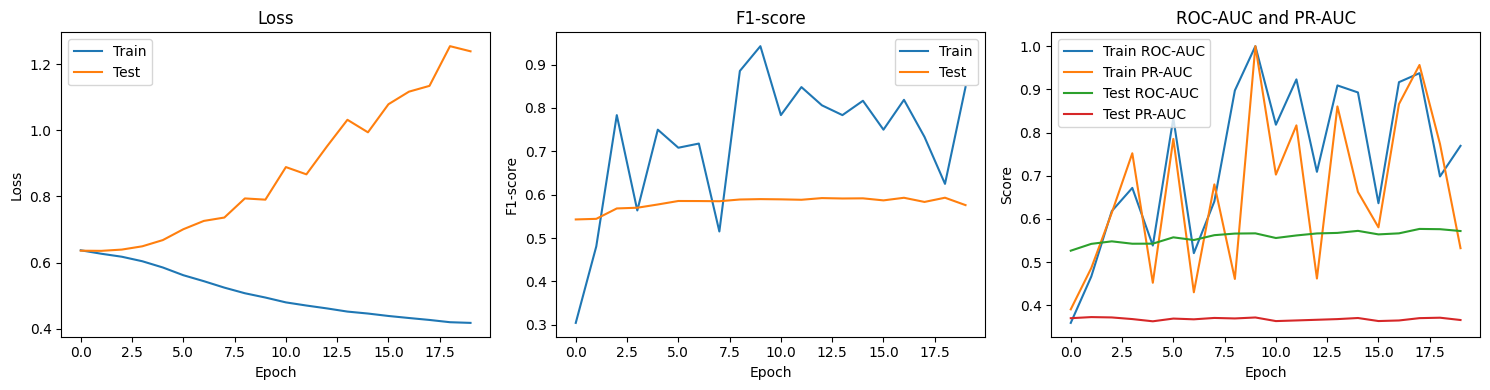

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1) 

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_1416/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_1416/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6801, Train F1-score: 0.5629, Train ROC-AUC: 0.5228, Train PR-AUC: 0.3501, Test Loss: 0.6605, Test F1-score: 0.5692, Test ROC-AUC: 0.4976, Test PR-AUC: 0.3443
Epoch [2/20], Train Loss: 0.6445, Train F1-score: 0.5739, Train ROC-AUC: 0.5324, Train PR-AUC: 0.3659, Test Loss: 0.6473, Test F1-score: 0.5423, Test ROC-AUC: 0.4986, Test PR-AUC: 0.3499
Epoch [3/20], Train Loss: 0.6372, Train F1-score: 0.5465, Train ROC-AUC: 0.5322, Train PR-AUC: 0.3726, Test Loss: 0.6412, Test F1-score: 0.5407, Test ROC-AUC: 0.4999, Test PR-AUC: 0.3511
Epoch [4/20], Train Loss: 0.6336, Train F1-score: 0.5452, Train ROC-AUC: 0.5388, Train PR-AUC: 0.3769, Test Loss: 0.6394, Test F1-score: 0.5409, Test ROC-AUC: 0.5036, Test PR-AUC: 0.3535
Epoch [5/20], Train Loss: 0.6330, Train F1-score: 0.5453, Train ROC-AUC: 0.5352, Train PR-AUC: 0.3797, Test Loss: 0.6395, Test F1-score: 0.5409, Test ROC-AUC: 0.5039, Test PR-AUC: 0.3549
Epoch [6/20], Train Loss: 0.6327, Train F1-score: 0.5460, Train R

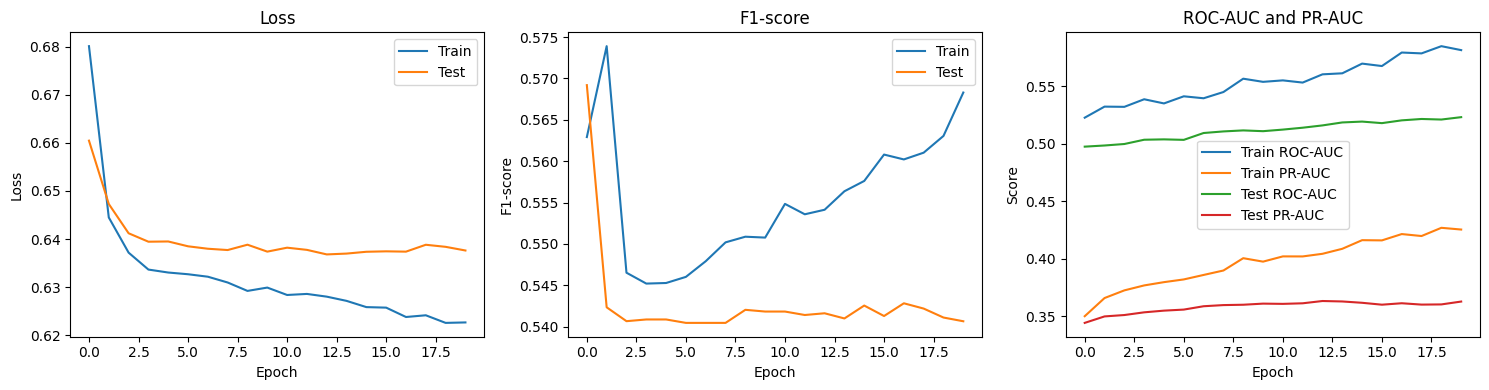

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature TFs_TP63 importance: 0.002008838891121023
Feature Histone_H3K4me2 importance: 0.0012053033346726139
Feature Histone_H3.6 importance: 0.0012053033346726139
Feature TFs_BrdU importance: 0.0012053033346726139
Feature TFs_NIPBL importance: 0.0012053033346726139
Feature TFs_SMARCA4 importance: 0.0012053033346726139
Feature Histone_H2A.X importance: 0.0008035355564484092
Feature Histone_H3 importance: 0.0008035355564484092
Feature Histone_H2A.Zac importance: 0.0008035355564484092
Feature Histone_H3K9ac importance: 0.0008035355564484092
Feature Histone_H3.7 importance: 0.0008035355564484092
Feature TFs_FOXK1 importance: 0.0008035355564484092
Feature TFs_GATAD2B importance: 0.0008035355564484092
Feature TFs_LMNA importance: 0.0008035355564484092
Feature TFs_PCF11 importance: 0.0008035355564484092
Feature TFs_REST importance: 0.0008035355564484092
Feature TFs_TBP importance: 0.0008035355564484092
Feature TFs_USF1 importance: 0.0008035355564484092
Feature TFs_YY2 importance: 0.0008035355

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1416/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1416/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6396, Train F1-score: 0.8167, Train ROC-AUC: 0.7857, Train PR-AUC: 0.5982, Test Loss: 0.6407, Test F1-score: 0.5368, Test ROC-AUC: 0.5121, Test PR-AUC: 0.3580
Epoch [2/20], Train Loss: 0.6348, Train F1-score: 0.7284, Train ROC-AUC: 0.4103, Train PR-AUC: 0.1465, Test Loss: 0.6369, Test F1-score: 0.5409, Test ROC-AUC: 0.5180, Test PR-AUC: 0.3607
Epoch [3/20], Train Loss: 0.6321, Train F1-score: 0.3333, Train ROC-AUC: 0.5625, Train PR-AUC: 0.5147, Test Loss: 0.6419, Test F1-score: 0.5456, Test ROC-AUC: 0.5079, Test PR-AUC: 0.3539
Epoch [4/20], Train Loss: 0.6307, Train F1-score: 0.4050, Train ROC-AUC: 0.6032, Train PR-AUC: 0.5497, Test Loss: 0.6383, Test F1-score: 0.5409, Test ROC-AUC: 0.5121, Test PR-AUC: 0.3579
Epoch [5/20], Train Loss: 0.6269, Train F1-score: 0.8482, Train ROC-AUC: 0.7436, Train PR-AUC: 0.5510, Test Loss: 0.6387, Test F1-score: 0.5508, Test ROC-AUC: 0.5297, Test PR-AUC: 0.3683
Epoch [6/20], Train Loss: 0.6249, Train F1-score: 0.5312, Train R

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1416/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1416/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6377, Train F1-score: 0.5465, Train ROC-AUC: 0.5214, Train PR-AUC: 0.3588, Test Loss: 0.6445, Test F1-score: 0.5566, Test ROC-AUC: 0.5031, Test PR-AUC: 0.3530
Epoch [2/20], Train Loss: 0.6276, Train F1-score: 0.5702, Train ROC-AUC: 0.5585, Train PR-AUC: 0.4071, Test Loss: 0.6372, Test F1-score: 0.5510, Test ROC-AUC: 0.5250, Test PR-AUC: 0.3679
Epoch [3/20], Train Loss: 0.6195, Train F1-score: 0.6007, Train ROC-AUC: 0.5900, Train PR-AUC: 0.4427, Test Loss: 0.6429, Test F1-score: 0.5635, Test ROC-AUC: 0.5334, Test PR-AUC: 0.3656
Epoch [4/20], Train Loss: 0.6084, Train F1-score: 0.6325, Train ROC-AUC: 0.6218, Train PR-AUC: 0.4807, Test Loss: 0.6432, Test F1-score: 0.5730, Test ROC-AUC: 0.5416, Test PR-AUC: 0.3780
Epoch [5/20], Train Loss: 0.5966, Train F1-score: 0.6581, Train ROC-AUC: 0.6519, Train PR-AUC: 0.5187, Test Loss: 0.6564, Test F1-score: 0.5830, Test ROC-AUC: 0.5468, Test PR-AUC: 0.3720
Epoch [6/20], Train Loss: 0.5862, Train F1-score: 0.6703, Train R

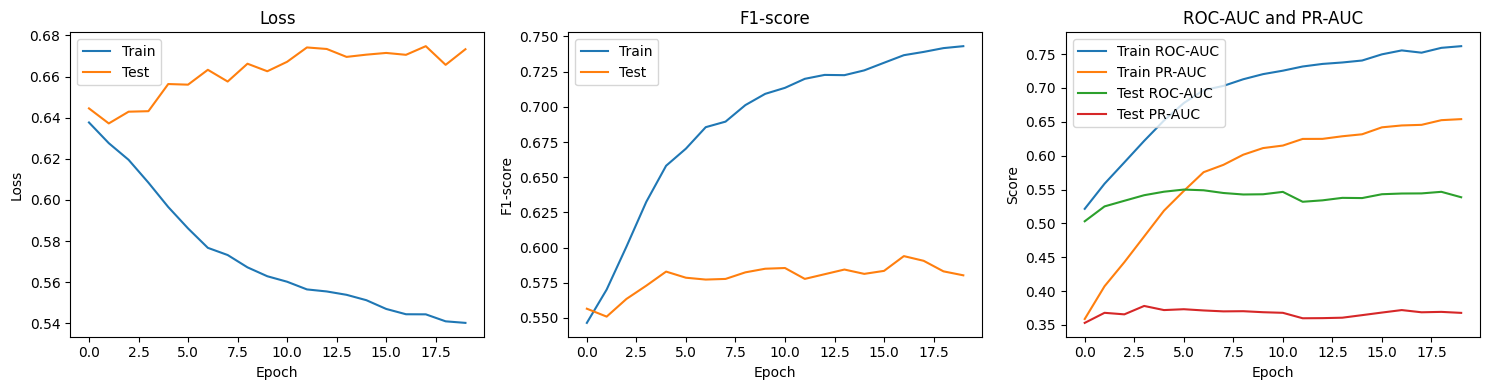

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_1416/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_1416/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6393, Train F1-score: 0.5403, Train ROC-AUC: 0.5239, Train PR-AUC: 0.3595, Test Loss: 0.6377, Test F1-score: 0.5356, Test ROC-AUC: 0.5104, Test PR-AUC: 0.3577
Epoch [2/30], Train Loss: 0.6307, Train F1-score: 0.5529, Train ROC-AUC: 0.5511, Train PR-AUC: 0.3937, Test Loss: 0.6378, Test F1-score: 0.5432, Test ROC-AUC: 0.5178, Test PR-AUC: 0.3594
Epoch [3/30], Train Loss: 0.6258, Train F1-score: 0.5683, Train ROC-AUC: 0.5720, Train PR-AUC: 0.4159, Test Loss: 0.6371, Test F1-score: 0.5504, Test ROC-AUC: 0.5261, Test PR-AUC: 0.3666
Epoch [4/30], Train Loss: 0.6187, Train F1-score: 0.5882, Train ROC-AUC: 0.5952, Train PR-AUC: 0.4390, Test Loss: 0.6398, Test F1-score: 0.5596, Test ROC-AUC: 0.5344, Test PR-AUC: 0.3657
Epoch [5/30], Train Loss: 0.6131, Train F1-score: 0.6010, Train ROC-AUC: 0.6092, Train PR-AUC: 0.4543, Test Loss: 0.6411, Test F1-score: 0.5600, Test ROC-AUC: 0.5395, Test PR-AUC: 0.3752
Epoch [6/30], Train Loss: 0.6051, Train F1-score: 0.6139, Train R

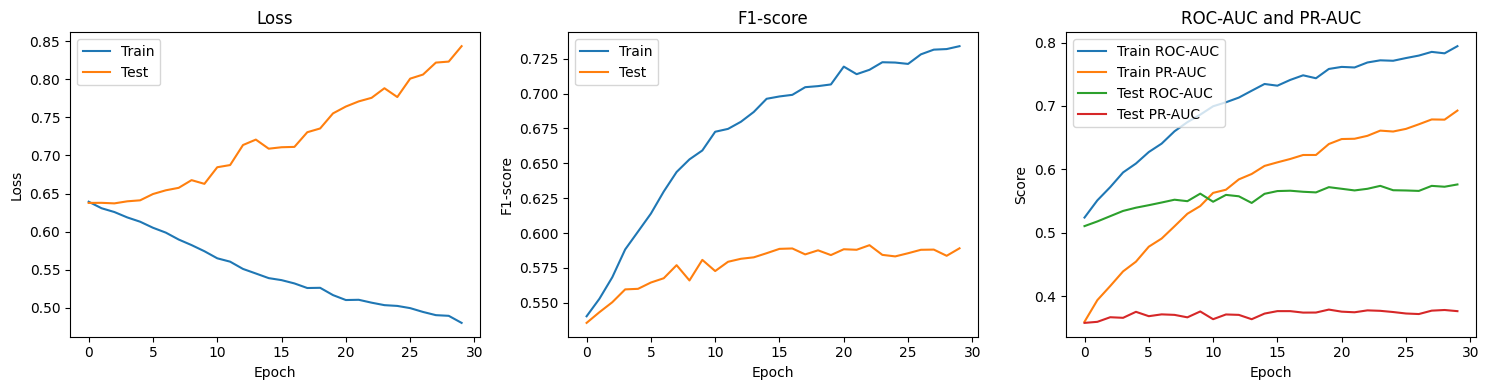

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_1416/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_1416/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.42it/s]


Epoch [1/20], Train Loss: 0.6414, Train F1-score: 0.5444, Train ROC-AUC: 0.5127, Train PR-AUC: 0.3515, Test Loss: 0.6395, Test F1-score: 0.5429, Test ROC-AUC: 0.5230, Test PR-AUC: 0.3657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.58it/s]


Epoch [2/20], Train Loss: 0.6335, Train F1-score: 0.5524, Train ROC-AUC: 0.5481, Train PR-AUC: 0.3879, Test Loss: 0.6423, Test F1-score: 0.5497, Test ROC-AUC: 0.5133, Test PR-AUC: 0.3630


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.08it/s]


Epoch [3/20], Train Loss: 0.6272, Train F1-score: 0.5707, Train ROC-AUC: 0.5632, Train PR-AUC: 0.4103, Test Loss: 0.6380, Test F1-score: 0.5618, Test ROC-AUC: 0.5349, Test PR-AUC: 0.3700


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.89it/s]


Epoch [4/20], Train Loss: 0.6234, Train F1-score: 0.5804, Train ROC-AUC: 0.5757, Train PR-AUC: 0.4217, Test Loss: 0.6354, Test F1-score: 0.5557, Test ROC-AUC: 0.5277, Test PR-AUC: 0.3702


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.41it/s]


Epoch [5/20], Train Loss: 0.6162, Train F1-score: 0.5934, Train ROC-AUC: 0.5978, Train PR-AUC: 0.4454, Test Loss: 0.6403, Test F1-score: 0.5685, Test ROC-AUC: 0.5485, Test PR-AUC: 0.3719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.57it/s]


Epoch [6/20], Train Loss: 0.6072, Train F1-score: 0.6168, Train ROC-AUC: 0.6225, Train PR-AUC: 0.4658, Test Loss: 0.6671, Test F1-score: 0.5717, Test ROC-AUC: 0.5327, Test PR-AUC: 0.3591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.66it/s]


Epoch [7/20], Train Loss: 0.5980, Train F1-score: 0.6305, Train ROC-AUC: 0.6315, Train PR-AUC: 0.4857, Test Loss: 0.6736, Test F1-score: 0.5748, Test ROC-AUC: 0.5493, Test PR-AUC: 0.3679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.89it/s]


Epoch [8/20], Train Loss: 0.5905, Train F1-score: 0.6424, Train ROC-AUC: 0.6505, Train PR-AUC: 0.5056, Test Loss: 0.6680, Test F1-score: 0.5745, Test ROC-AUC: 0.5512, Test PR-AUC: 0.3673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.12it/s]


Epoch [9/20], Train Loss: 0.5805, Train F1-score: 0.6521, Train ROC-AUC: 0.6646, Train PR-AUC: 0.5248, Test Loss: 0.6749, Test F1-score: 0.5707, Test ROC-AUC: 0.5469, Test PR-AUC: 0.3627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.00it/s]


Epoch [10/20], Train Loss: 0.5736, Train F1-score: 0.6593, Train ROC-AUC: 0.6747, Train PR-AUC: 0.5360, Test Loss: 0.6858, Test F1-score: 0.5741, Test ROC-AUC: 0.5459, Test PR-AUC: 0.3571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.65it/s]


Epoch [11/20], Train Loss: 0.5623, Train F1-score: 0.6661, Train ROC-AUC: 0.6829, Train PR-AUC: 0.5573, Test Loss: 0.7133, Test F1-score: 0.5813, Test ROC-AUC: 0.5583, Test PR-AUC: 0.3660


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.15it/s]


Epoch [12/20], Train Loss: 0.5571, Train F1-score: 0.6737, Train ROC-AUC: 0.6933, Train PR-AUC: 0.5660, Test Loss: 0.6895, Test F1-score: 0.5746, Test ROC-AUC: 0.5583, Test PR-AUC: 0.3660


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.81it/s]


Epoch [13/20], Train Loss: 0.5497, Train F1-score: 0.6778, Train ROC-AUC: 0.7103, Train PR-AUC: 0.5845, Test Loss: 0.7511, Test F1-score: 0.5834, Test ROC-AUC: 0.5501, Test PR-AUC: 0.3613


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.45it/s]


Epoch [14/20], Train Loss: 0.5436, Train F1-score: 0.6841, Train ROC-AUC: 0.7176, Train PR-AUC: 0.5915, Test Loss: 0.7285, Test F1-score: 0.5811, Test ROC-AUC: 0.5554, Test PR-AUC: 0.3641


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.43it/s]


Epoch [15/20], Train Loss: 0.5397, Train F1-score: 0.6884, Train ROC-AUC: 0.7170, Train PR-AUC: 0.6003, Test Loss: 0.7618, Test F1-score: 0.5709, Test ROC-AUC: 0.5540, Test PR-AUC: 0.3640


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 71.59it/s]


Epoch [16/20], Train Loss: 0.5314, Train F1-score: 0.6963, Train ROC-AUC: 0.7300, Train PR-AUC: 0.6110, Test Loss: 0.7391, Test F1-score: 0.5787, Test ROC-AUC: 0.5603, Test PR-AUC: 0.3654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 71.13it/s]


Epoch [17/20], Train Loss: 0.5263, Train F1-score: 0.7010, Train ROC-AUC: 0.7325, Train PR-AUC: 0.6144, Test Loss: 0.7934, Test F1-score: 0.5713, Test ROC-AUC: 0.5489, Test PR-AUC: 0.3604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 70.89it/s]


Epoch [18/20], Train Loss: 0.5196, Train F1-score: 0.7043, Train ROC-AUC: 0.7489, Train PR-AUC: 0.6309, Test Loss: 0.8716, Test F1-score: 0.5900, Test ROC-AUC: 0.5522, Test PR-AUC: 0.3626


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 71.58it/s]


Epoch [19/20], Train Loss: 0.5117, Train F1-score: 0.7117, Train ROC-AUC: 0.7487, Train PR-AUC: 0.6385, Test Loss: 0.8369, Test F1-score: 0.5952, Test ROC-AUC: 0.5751, Test PR-AUC: 0.3747


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 70.68it/s]


Epoch [20/20], Train Loss: 0.5083, Train F1-score: 0.7147, Train ROC-AUC: 0.7612, Train PR-AUC: 0.6492, Test Loss: 0.7899, Test F1-score: 0.5922, Test ROC-AUC: 0.5552, Test PR-AUC: 0.3634


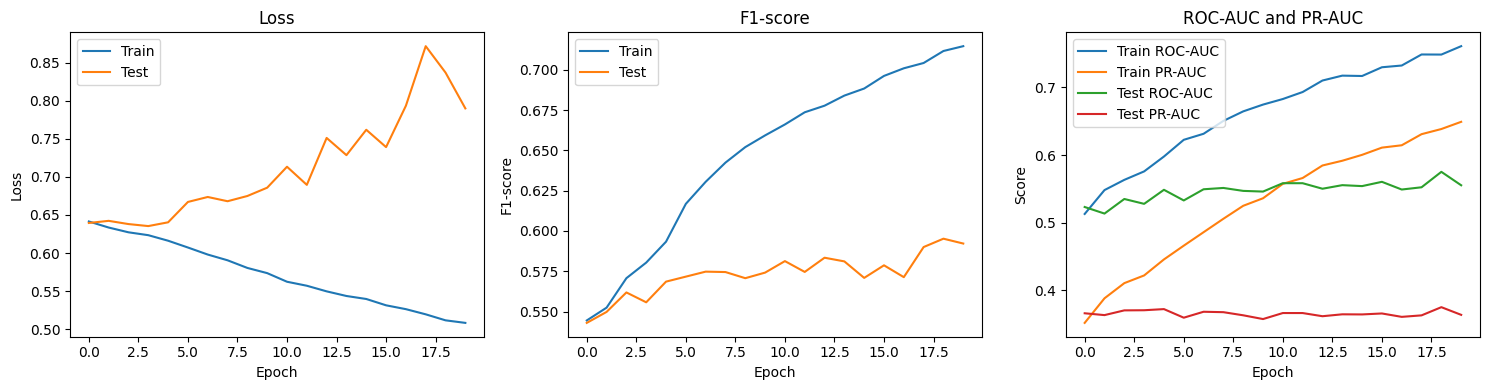

In [34]:
# Создание графиков метрик
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 128
output_size = 2

model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)
        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.7384, Train F1-score: 0.3696, Train ROC-AUC: 0.4970, Train PR-AUC: 0.3344, Test Loss: 0.7080, Test F1-score: 0.3709, Test ROC-AUC: 0.5019, Test PR-AUC: 0.3357
Epoch [2/50], Train Loss: 0.7097, Train F1-score: 0.5753, Train ROC-AUC: 0.5023, Train PR-AUC: 0.3401, Test Loss: 0.6897, Test F1-score: 0.5645, Test ROC-AUC: 0.5004, Test PR-AUC: 0.3342
Epoch [3/50], Train Loss: 0.6881, Train F1-score: 0.5870, Train ROC-AUC: 0.5100, Train PR-AUC: 0.3484, Test Loss: 0.6750, Test F1-score: 0.5651, Test ROC-AUC: 0.4968, Test PR-AUC: 0.3343
Epoch [4/50], Train Loss: 0.6703, Train F1-score: 0.5767, Train ROC-AUC: 0.5154, Train PR-AUC: 0.3567, Test Loss: 0.6645, Test F1-score: 0.5657, Test ROC-AUC: 0.4921, Test PR-AUC: 0.3321
Epoch [5/50], Train Loss: 0.6573, Train F1-score: 0.5706, Train ROC-AUC: 0.5194, Train PR-AUC: 0.3614, Test Loss: 0.6576, Test F1-score: 0.5459, Test ROC-AUC: 0.4891, Test PR-AUC: 0.3312
Epoch [6/50], Train Loss: 0.6480, Train F1-score: 0.5646, Train R

Epoch [45/50], Train Loss: 0.6111, Train F1-score: 0.5862, Train ROC-AUC: 0.6129, Train PR-AUC: 0.4538, Test Loss: 0.6434, Test F1-score: 0.5568, Test ROC-AUC: 0.5276, Test PR-AUC: 0.3628
Epoch [46/50], Train Loss: 0.6106, Train F1-score: 0.5872, Train ROC-AUC: 0.6145, Train PR-AUC: 0.4557, Test Loss: 0.6436, Test F1-score: 0.5560, Test ROC-AUC: 0.5283, Test PR-AUC: 0.3632
Epoch [47/50], Train Loss: 0.6101, Train F1-score: 0.5873, Train ROC-AUC: 0.6161, Train PR-AUC: 0.4573, Test Loss: 0.6437, Test F1-score: 0.5555, Test ROC-AUC: 0.5291, Test PR-AUC: 0.3638
Epoch [48/50], Train Loss: 0.6096, Train F1-score: 0.5872, Train ROC-AUC: 0.6176, Train PR-AUC: 0.4589, Test Loss: 0.6439, Test F1-score: 0.5564, Test ROC-AUC: 0.5302, Test PR-AUC: 0.3643
Epoch [49/50], Train Loss: 0.6090, Train F1-score: 0.5878, Train ROC-AUC: 0.6193, Train PR-AUC: 0.4609, Test Loss: 0.6441, Test F1-score: 0.5564, Test ROC-AUC: 0.5312, Test PR-AUC: 0.3649
Epoch [50/50], Train Loss: 0.6085, Train F1-score: 0.5889, T

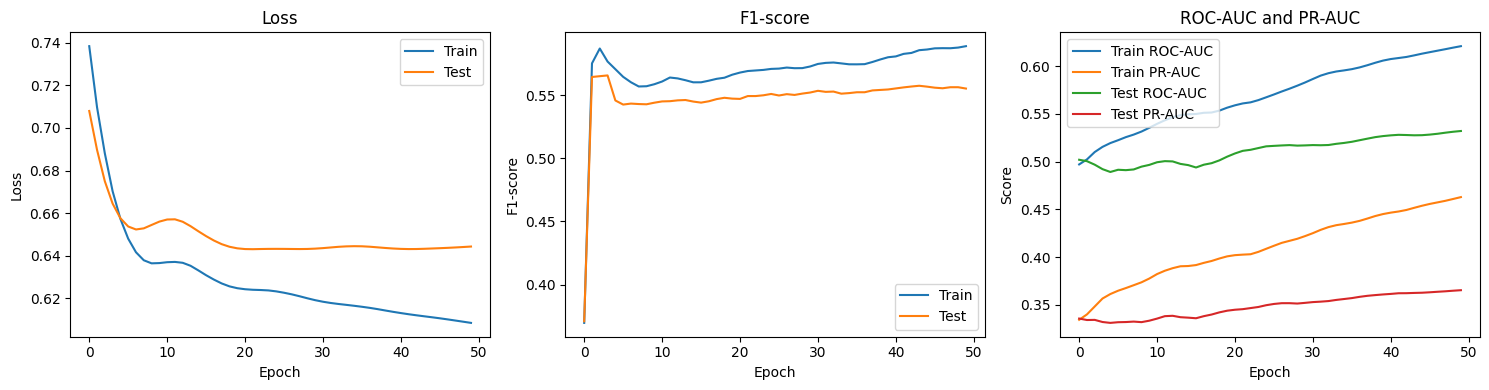

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [37]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [38]:
df_x

,Histone_H3K36me3,Histone_H3K18ub,Histone_H4K20me3,Histone_H2BK120ub,Histone_H4K20me2,Histone_H3K36me2,Histone_H4K20me1,Histone_H3K27ac,Histone_H2A.X,Histone_H3.Y,...,TFs_ZBTB17,TFs_ZBTB48,TFs_ZBTB7A,TFs_ZFP36,TFs_ZHX1,TFs_ZKSCAN1,TFs_ZMYND8,TFs_ZNF143,TFs_ZNF274,TFs_ZZZ3
0,-0.242203,-0.024164,-0.213406,-0.039406,-0.06171,-0.170359,-0.150266,-0.723743,-0.079739,-0.451620,...,-0.086582,-0.379861,-0.328395,-0.101559,-0.048757,-0.153990,-0.072668,-0.201575,-0.044978,-0.064745
1,-0.242203,-0.024164,0.564040,-0.039406,-0.06171,-0.170359,0.306312,1.963741,-0.079739,-0.451620,...,-0.086582,-0.379861,1.432420,-0.101559,-0.048757,0.376319,-0.072668,-0.106030,-0.044978,-0.064745
2,-0.242203,-0.024164,-0.213406,-0.039406,-0.06171,-0.170359,-0.150266,-0.744281,-0.079739,-0.451620,...,-0.086582,-0.379861,-0.328395,-0.101559,-0.048757,-0.153990,-0.072668,-0.201575,-0.044978,-0.064745
3,0.788033,-0.024164,0.652799,-0.039406,-0.06171,-0.170359,0.037807,0.694985,-0.079739,-0.451620,...,-0.086582,-0.379861,-0.070443,-0.101559,-0.048757,-0.153990,-0.072668,-0.070804,-0.044978,-0.064745
4,-0.242203,-0.024164,-0.213406,-0.039406,-0.06171,-0.170359,-0.150266,0.923316,-0.079739,1.023482,...,-0.086582,0.895628,0.264775,-0.101559,-0.048757,-0.153990,-0.072668,0.580201,-0.044978,-0.064745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12436,-0.242203,-0.024164,-0.213406,-0.039406,-0.06171,-0.170359,-0.150266,-0.792362,-0.079739,-0.451620,...,-0.086582,0.122823,-0.328395,-0.101559,-0.048757,-0.153990,-0.072668,-0.201575,-0.044978,-0.064745
12437,-0.242203,-0.024164,-0.213406,-0.039406,-0.06171,-0.170359,-0.150266,-0.613046,-0.079739,-0.141301,...,-0.086582,-0.379861,-0.328395,-0.101559,-0.048757,-0.153990,-0.072668,-0.128354,-0.044978,-0.064745
12438,-0.242203,-0.024164,-0.213406,-0.039406,-0.06171,-0.170359,-0.150266,0.688870,-0.079739,1.626589,...,-0.086582,-0.066306,-0.328395,-0.101559,-0.048757,0.157245,-0.072668,-0.201575,-0.044978,-0.064745
12439,0.102081,-0.024164,-0.213406,22.835838,-0.06171,1.929153,-0.150266,2.555961,-0.079739,7.608770,...,-0.086582,0.506075,-0.328395,0.762574,-0.048757,0.924038,-0.072668,-0.067093,-0.044978,-0.064745


In [39]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [40]:
df_y

,target
0,0
1,1
2,0
3,1
4,1
...,...
12436,1
12437,0
12438,0
12439,1


In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_1416/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.006055614200942255
Histone_H3K18ub: 8.395268109502726e-05
Histone_H4K20me3: 0.003672395932776238
Histone_H2BK120ub: 5.348185743651746e-05
Histone_H4K20me2: 0.00033369610996808187
Histone_H3K36me2: 0.0014302315477253114
Histone_H4K20me1: 0.006198554361346091
Histone_H3K27ac: 0.03552448987839126
Histone_H2A.X: 0.0014725385029210171
Histone_H3.Y: 0.0062884477590273114
Histone_H3K9me3: 0.026211593356577464
Histone_H3K9me2: 0.00038136518652040605
Histone_H2A.Z: 0.010731301500789804
Histone_H3K18ac: 0.0061453197965669806
Histone_CENPA: 0.0041134192173256775
Histone_H3: 0.027843361490062026
Histone_H3K79me3: 0.004025917302763794
Histone_H3K79me2: 0.0026116905400733696
Histone_H3R3me2: 0.0001057964129671426
Histone_H2A.Z.2: 3.073103098316168e-05
Histone_H3K9K14ac: 0.0022228007500050867
Histone_H2A.Zac: 0.01001068976182546
Histone_H2A.XS139ph: 0.019733419846227694
Histone_H4ac: 0.0031352149791339483
Histone_H2A.Z.1: 0.0008927950058529542
Histone_H3K9ac: 0.0071609423315623
Hi

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_1416/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.2704
ROC-AUC: 0.5230
PR-AUC: 0.4335


               feature  importance
7      Histone_H3K27ac    0.035612
28     Histone_H3K4me3    0.029247
15          Histone_H3    0.026155
10     Histone_H3K9me3    0.025275
30     Histone_H3K4me1    0.023641
..                 ...         ...
38        Histone_H3.1    0.000004
175         TFs_POLRMT    0.000000
219          TFs_TFB2M    0.000000
108          TFs_GRWD1    0.000000
40   Histone_H2AK119Ub    0.000000

[244 rows x 2 columns]


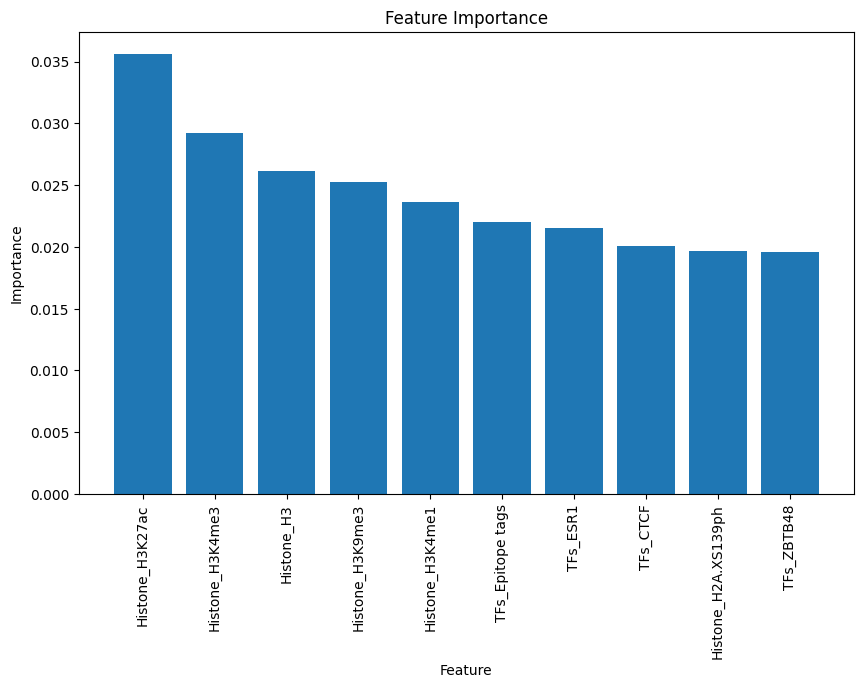

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [44]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6813513	total: 55.5ms	remaining: 55.5s
1:	learn: 0.6718901	total: 63.5ms	remaining: 31.7s
2:	learn: 0.6638493	total: 70.6ms	remaining: 23.5s
3:	learn: 0.6576506	total: 78.3ms	remaining: 19.5s
4:	learn: 0.6524278	total: 85.8ms	remaining: 17.1s
5:	learn: 0.6482862	total: 92.8ms	remaining: 15.4s
6:	learn: 0.6447257	total: 100ms	remaining: 14.2s
7:	learn: 0.6420349	total: 107ms	remaining: 13.3s
8:	learn: 0.6396525	total: 114ms	remaining: 12.6s
9:	learn: 0.6375358	total: 121ms	remaining: 12s
10:	learn: 0.6359116	total: 129ms	remaining: 11.6s
11:	learn: 0.6346246	total: 136ms	remaining: 11.2s
12:	learn: 0.6334712	total: 144ms	remaining: 10.9s
13:	learn: 0.6325214	total: 150ms	remaining: 10.6s
14:	learn: 0.6313214	total: 158ms	remaining: 10.4s
15:	learn: 0.6302562	total: 165ms	remaining: 10.2s
16:	learn: 0.6289123	total: 173ms	remaining: 9.97s
17:	learn: 0.6285003	total: 180ms	remaining: 9.8s
18:	learn: 0.6274791	total: 187ms	remaining: 9.63s
19:	learn: 0.6265634	total: 194ms	rema

162:	learn: 0.5385224	total: 1.25s	remaining: 6.43s
163:	learn: 0.5377375	total: 1.26s	remaining: 6.42s
164:	learn: 0.5374449	total: 1.27s	remaining: 6.41s
165:	learn: 0.5368571	total: 1.27s	remaining: 6.4s
166:	learn: 0.5363182	total: 1.28s	remaining: 6.39s
167:	learn: 0.5359364	total: 1.29s	remaining: 6.38s
168:	learn: 0.5355183	total: 1.3s	remaining: 6.38s
169:	learn: 0.5350911	total: 1.3s	remaining: 6.37s
170:	learn: 0.5344514	total: 1.31s	remaining: 6.36s
171:	learn: 0.5336072	total: 1.32s	remaining: 6.35s
172:	learn: 0.5332403	total: 1.33s	remaining: 6.34s
173:	learn: 0.5325669	total: 1.33s	remaining: 6.33s
174:	learn: 0.5315968	total: 1.34s	remaining: 6.33s
175:	learn: 0.5310199	total: 1.35s	remaining: 6.32s
176:	learn: 0.5306570	total: 1.36s	remaining: 6.31s
177:	learn: 0.5300903	total: 1.36s	remaining: 6.3s
178:	learn: 0.5294426	total: 1.37s	remaining: 6.29s
179:	learn: 0.5284377	total: 1.38s	remaining: 6.28s
180:	learn: 0.5279183	total: 1.39s	remaining: 6.27s
181:	learn: 0.52

324:	learn: 0.4570114	total: 2.46s	remaining: 5.11s
325:	learn: 0.4565236	total: 2.47s	remaining: 5.1s
326:	learn: 0.4561726	total: 2.48s	remaining: 5.09s
327:	learn: 0.4556808	total: 2.48s	remaining: 5.09s
328:	learn: 0.4551378	total: 2.49s	remaining: 5.08s
329:	learn: 0.4547540	total: 2.5s	remaining: 5.07s
330:	learn: 0.4541748	total: 2.5s	remaining: 5.06s
331:	learn: 0.4538299	total: 2.51s	remaining: 5.05s
332:	learn: 0.4534257	total: 2.52s	remaining: 5.05s
333:	learn: 0.4533154	total: 2.53s	remaining: 5.04s
334:	learn: 0.4527038	total: 2.53s	remaining: 5.03s
335:	learn: 0.4522266	total: 2.54s	remaining: 5.02s
336:	learn: 0.4519029	total: 2.55s	remaining: 5.01s
337:	learn: 0.4516021	total: 2.56s	remaining: 5s
338:	learn: 0.4513716	total: 2.56s	remaining: 5s
339:	learn: 0.4508875	total: 2.57s	remaining: 4.99s
340:	learn: 0.4506735	total: 2.58s	remaining: 4.98s
341:	learn: 0.4504650	total: 2.58s	remaining: 4.97s
342:	learn: 0.4499805	total: 2.59s	remaining: 4.96s
343:	learn: 0.4496094

490:	learn: 0.3999555	total: 3.67s	remaining: 3.81s
491:	learn: 0.3997049	total: 3.68s	remaining: 3.8s
492:	learn: 0.3994642	total: 3.69s	remaining: 3.79s
493:	learn: 0.3991271	total: 3.69s	remaining: 3.78s
494:	learn: 0.3988986	total: 3.7s	remaining: 3.78s
495:	learn: 0.3985397	total: 3.71s	remaining: 3.77s
496:	learn: 0.3982966	total: 3.71s	remaining: 3.76s
497:	learn: 0.3980179	total: 3.72s	remaining: 3.75s
498:	learn: 0.3977174	total: 3.73s	remaining: 3.75s
499:	learn: 0.3973189	total: 3.74s	remaining: 3.74s
500:	learn: 0.3969098	total: 3.74s	remaining: 3.73s
501:	learn: 0.3964912	total: 3.75s	remaining: 3.72s
502:	learn: 0.3962188	total: 3.76s	remaining: 3.71s
503:	learn: 0.3960028	total: 3.77s	remaining: 3.71s
504:	learn: 0.3956274	total: 3.77s	remaining: 3.7s
505:	learn: 0.3951031	total: 3.78s	remaining: 3.69s
506:	learn: 0.3947303	total: 3.79s	remaining: 3.68s
507:	learn: 0.3945319	total: 3.8s	remaining: 3.68s
508:	learn: 0.3941953	total: 3.8s	remaining: 3.67s
509:	learn: 0.394

656:	learn: 0.3583804	total: 4.88s	remaining: 2.55s
657:	learn: 0.3579953	total: 4.89s	remaining: 2.54s
658:	learn: 0.3577330	total: 4.9s	remaining: 2.54s
659:	learn: 0.3575929	total: 4.91s	remaining: 2.53s
660:	learn: 0.3575585	total: 4.92s	remaining: 2.52s
661:	learn: 0.3573461	total: 4.92s	remaining: 2.51s
662:	learn: 0.3570623	total: 4.93s	remaining: 2.5s
663:	learn: 0.3568862	total: 4.94s	remaining: 2.5s
664:	learn: 0.3563315	total: 4.94s	remaining: 2.49s
665:	learn: 0.3562362	total: 4.95s	remaining: 2.48s
666:	learn: 0.3559599	total: 4.96s	remaining: 2.48s
667:	learn: 0.3557710	total: 4.97s	remaining: 2.47s
668:	learn: 0.3553487	total: 4.97s	remaining: 2.46s
669:	learn: 0.3551832	total: 4.98s	remaining: 2.45s
670:	learn: 0.3549249	total: 4.99s	remaining: 2.45s
671:	learn: 0.3546666	total: 5s	remaining: 2.44s
672:	learn: 0.3544184	total: 5s	remaining: 2.43s
673:	learn: 0.3542612	total: 5.01s	remaining: 2.42s
674:	learn: 0.3540847	total: 5.02s	remaining: 2.42s
675:	learn: 0.3537454

822:	learn: 0.3262192	total: 6.09s	remaining: 1.31s
823:	learn: 0.3260505	total: 6.1s	remaining: 1.3s
824:	learn: 0.3257783	total: 6.11s	remaining: 1.29s
825:	learn: 0.3254397	total: 6.12s	remaining: 1.29s
826:	learn: 0.3252815	total: 6.12s	remaining: 1.28s
827:	learn: 0.3250937	total: 6.13s	remaining: 1.27s
828:	learn: 0.3249563	total: 6.14s	remaining: 1.27s
829:	learn: 0.3246857	total: 6.15s	remaining: 1.26s
830:	learn: 0.3245249	total: 6.15s	remaining: 1.25s
831:	learn: 0.3245161	total: 6.16s	remaining: 1.24s
832:	learn: 0.3243669	total: 6.17s	remaining: 1.24s
833:	learn: 0.3241739	total: 6.17s	remaining: 1.23s
834:	learn: 0.3240318	total: 6.18s	remaining: 1.22s
835:	learn: 0.3239396	total: 6.19s	remaining: 1.21s
836:	learn: 0.3237730	total: 6.2s	remaining: 1.21s
837:	learn: 0.3236405	total: 6.2s	remaining: 1.2s
838:	learn: 0.3234934	total: 6.21s	remaining: 1.19s
839:	learn: 0.3232944	total: 6.22s	remaining: 1.18s
840:	learn: 0.3231872	total: 6.22s	remaining: 1.18s
841:	learn: 0.323

987:	learn: 0.3007599	total: 7.3s	remaining: 88.7ms
988:	learn: 0.3006619	total: 7.31s	remaining: 81.3ms
989:	learn: 0.3005152	total: 7.32s	remaining: 73.9ms
990:	learn: 0.3003701	total: 7.32s	remaining: 66.5ms
991:	learn: 0.3002179	total: 7.33s	remaining: 59.1ms
992:	learn: 0.3000988	total: 7.34s	remaining: 51.7ms
993:	learn: 0.2999495	total: 7.34s	remaining: 44.3ms
994:	learn: 0.2997873	total: 7.35s	remaining: 37ms
995:	learn: 0.2995264	total: 7.36s	remaining: 29.6ms
996:	learn: 0.2994457	total: 7.37s	remaining: 22.2ms
997:	learn: 0.2991816	total: 7.38s	remaining: 14.8ms
998:	learn: 0.2989715	total: 7.38s	remaining: 7.39ms
999:	learn: 0.2988368	total: 7.39s	remaining: 0us
F1: 0.2706883217324053, AUC-ROC: 0.5193656162349447, PR-ROC: 0.34572774674451817


In [45]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 0.715801539414672
Histone_H3K18ub: 0.01165068620000453
Histone_H4K20me3: 0.2065832175965316
Histone_H2BK120ub: 0.0032273515075876133
Histone_H4K20me2: 0.03156020959358554
Histone_H3K36me2: 0.12491194983467548
Histone_H4K20me1: 1.1515036734410027
Histone_H3K27ac: 4.3762603703528855
Histone_H2A.X: 0.09919294884964731
Histone_H3.Y: 0.4849290149289399
Histone_H3K9me3: 2.5545822319636824
Histone_H3K9me2: 0.03640189260976459
Histone_H2A.Z: 0.7048843017603088
Histone_H3K18ac: 0.5532863579048913
Histone_CENPA: 0.3803950124434468
Histone_H3: 3.1935023907101674
Histone_H3K79me3: 0.3396269714002645
Histone_H3K79me2: 0.06659437343564353
Histone_H3R3me2: 0.0
Histone_H2A.Z.2: 0.0
Histone_H3K9K14ac: 0.18525232943194467
Histone_H2A.Zac: 0.9673889533987164
Histone_H2A.XS139ph: 2.0370921342376542
Histone_H4ac: 0.36859461872130717
Histone_H2A.Z.1: 0.07614532692865973
Histone_H3K9ac: 0.5353469683251864
Histone_H3K4me2: 1.1677433342753705
Histone_H3R17me2: 0.0
Histone_H3K4me3: 2.989344958

              feature  importance
7     Histone_H3K27ac    4.376260
15         Histone_H3    3.193502
28    Histone_H3K4me3    2.989345
88   TFs_Epitope tags    2.893751
30    Histone_H3K4me1    2.740933
..                ...         ...
171          TFs_PAX8    0.000000
34       Histone_H3.7    0.000000
19    Histone_H2A.Z.2    0.000000
86          TFs_EPAS1    0.000000
149         TFs_MORC2    0.000000

[244 rows x 2 columns]


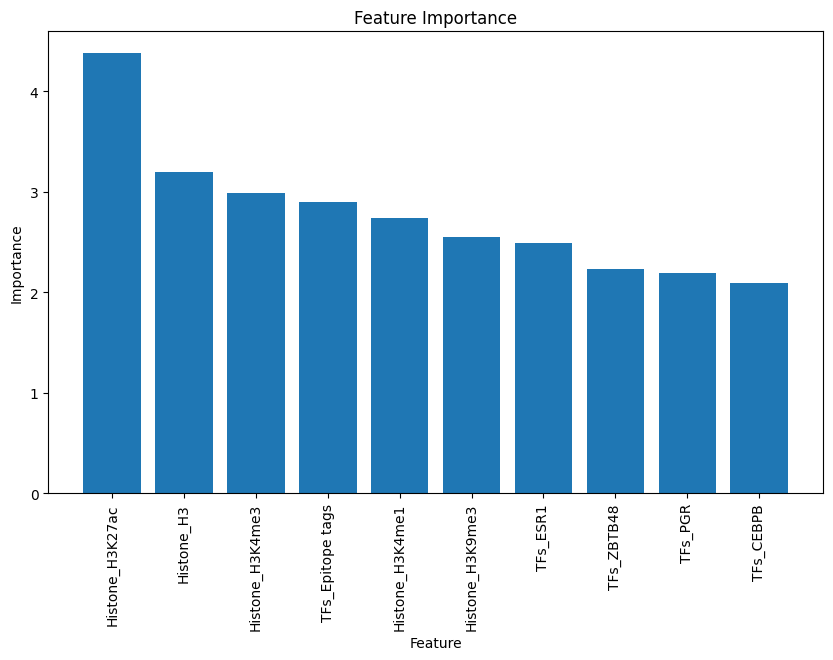

In [46]:
importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
